# Прогнозирование вероятности оттока пользователей для фитнес-центров

## Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import itertools

<div style="border:solid blue 1px; padding: 20px"> 
Сохраним данные в переменной data

In [2]:
data = pd.read_csv('/datasets/gym_churn.csv')

## Исследовательский анализ данных (EDA)

<div style="border:solid blue 1px; padding: 20px"> 
Изучим датасет

In [3]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [5]:
data.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


<div style="border:solid blue 1px; padding: 20px"> 
Данные представлены в виде целых и вещественных чисел, в них нет пропусков.

Признаки "пол", "проживание или работа в районе, где находится фитнес-центр", "сотрудник компании-партнёра клуба", "факт первоначальной записи в рамках акции «приведи друга»", "наличие контактного телефона", "факт посещения групповых занятий" представлены в виде бинарной классификации.
Примем за 1 и 0 следующее:
- "пол":
    - 1 - женщина;
    - 0 - мужчина;
- "проживание или работа в районе, где находится фитнес-центр":
    - 1 - да;
    - 0 - нет;
- "сотрудник компании-партнёра клуба":
    - 1 - да;
    - 0 - нет;
- "факт первоначальной записи в рамках акции «приведи друга»":
    - 1 - да;
    - 0 - нет;
- "наличие контактного телефона":
    - 1 - да;
    - 0 - нет;
- "факт посещения групповых занятий":
    - 1 - да;
    - 0 - нет;  
- "факт оттока в текущем месяце":
    - 1 - да;
    - 0 - нет;    

Таким образом 51% клиентов фитнес-центра - женщины, 84,5% живут или работают поблизости, 48,7% - сотрудники компании-партнёра клуба, 30,8% записались в рамках акции "приведи друга", 90,4% предоставили свой контактный телефон, 41,2% посещают групповые занятия и 26,5% клиентов покинули фитнес-клуб в текущем месяце

Самый популярный тариф - 1 месяц, им пользуется 50% клиентов. Также можно оформить абонемент на 6 месяцев и на год.

Минимальный возраст клиента - 18 лет, максимальный - 41 год.

Суммарная выручка от других услуг фитнес-центра в среднем составляет 146,94.

В среднем по выборке с момента первого обращения в фитнес-центр прошло ~4 месяцев. Самый преданный клиент посещает фитнес-клуб уже 31 месяц (2,5 года).

Так как самый популярный тариф на 1 месяц, то и самый распространенный срок до конца действия абонемента - 1 месяц.

Средняя частота посещений в неделю в неделю за предыдущий месяц и за все время с начала действия абонемента в целом по выборке примерно одинаковая.

<div style="border:solid blue 1px; padding: 20px"> 
Приведем названия столбцов к нижнему регистру

In [6]:
data.columns = data.columns.str.lower()

<div style="border:solid blue 1px; padding: 20px"> 
Проверим данные на явные дубликаты

In [7]:
data.duplicated().sum()

0

<div style="border:solid blue 1px; padding: 20px"> 
Явных дубликатов нет

<div style="border:solid blue 1px; padding: 20px"> 
Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [8]:
data.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


<div style="border:solid blue 1px; padding: 20px"> 
Различия среди клиентов, кто ушел и тех, кто остался наблюдаются в следующих признаках:

- <b> Среди тех, кто ушел </b> меньше клиентов, живущих/работающих поблизости от фитнес-центра (76,8% против 87,3%);
- Меньше клиентов, записавшихся в рамках акции "приведи друга" (35,5% против 53,4%);
- Меньше клиентов, являющихся сотрудниками компании-партнёра клуба (18,4% против 35,4%);
- Длительность абонемента в среднем ставляет ~2 месяца, в отличие от ~6 месяцев у оставшихся клиентов;
- Меньше клиентов, посещающих групповые занятия (26,9% против 46,4%);
- Меньше суммарная выручка от других услуг фитнес-центра (115 против 158);
- С момента первого обращения в фитнес-центр прошло в среднем менее месяца;
- Посещаемость занятий снизилась с 1,5 занятий в неделю за все время действия абонемента до 1 за предыдущий месяц.

<div style="border:solid blue 1px; padding: 20px"> 
Построим графики распределения клиентов по признакам для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

In [9]:
category_columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']
discrete_columns = ['contract_period', 'age', 'month_to_end_contract', 'lifetime']
numeric_columns = ['avg_additional_charges_total', 'avg_class_frequency_total', 'avg_class_frequency_current_month']

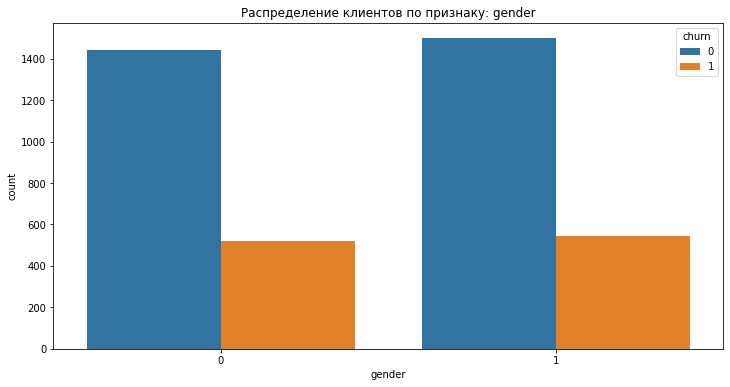

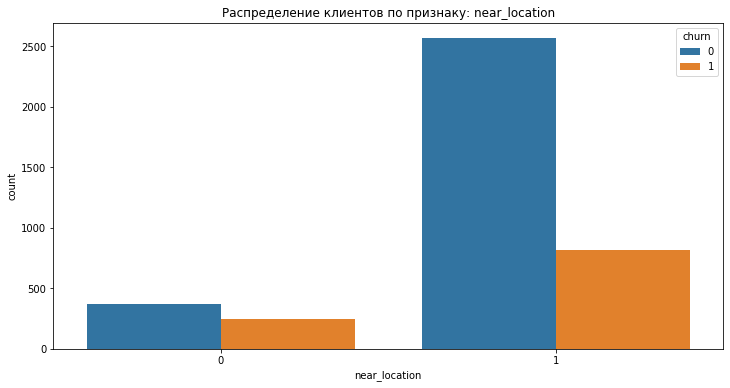

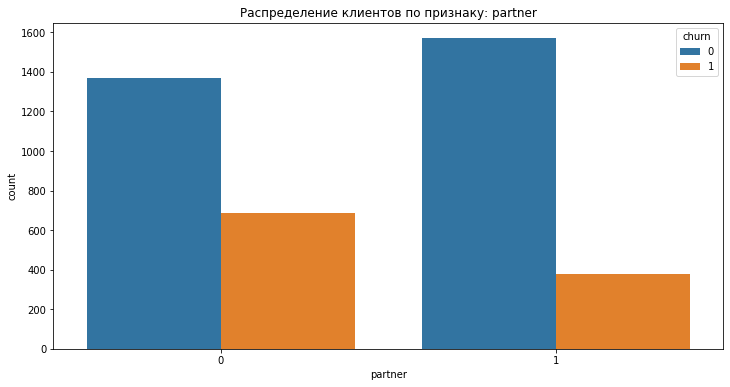

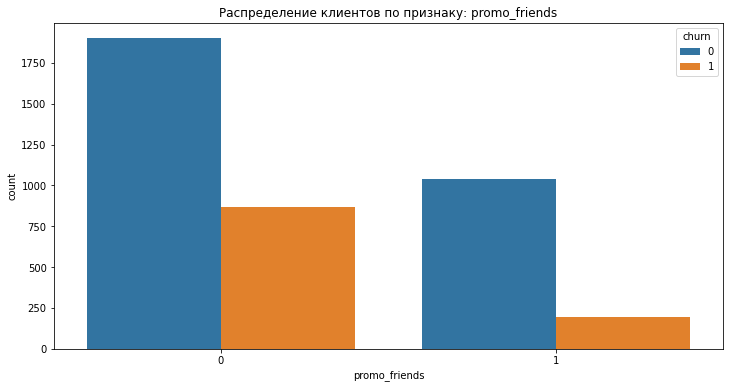

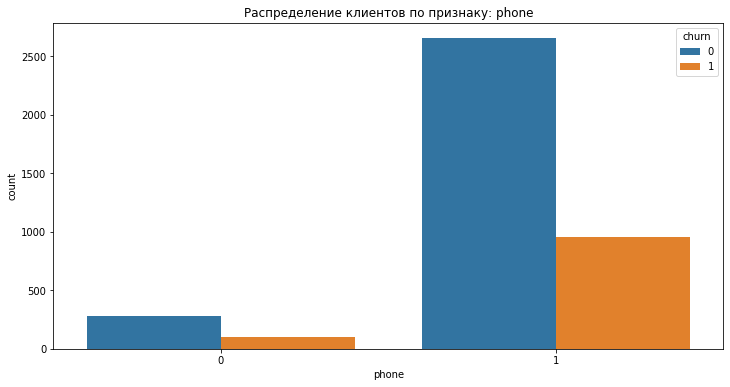

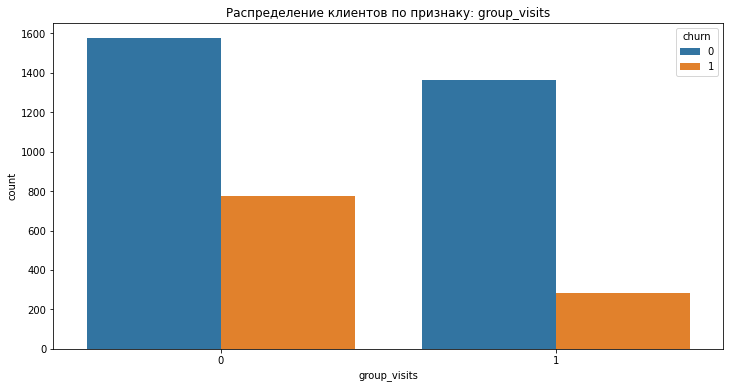

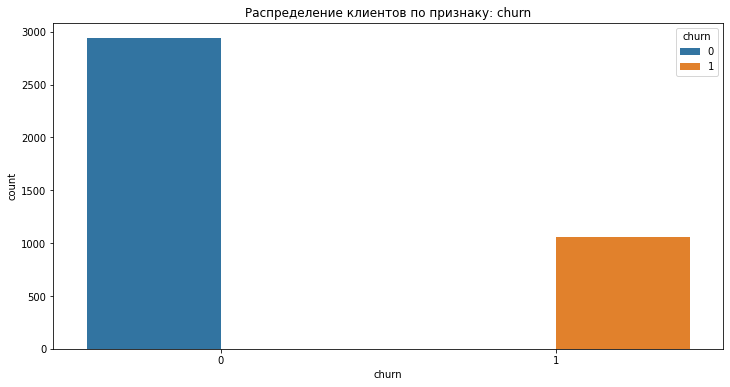

In [10]:
for feature in category_columns:
    plt.figure(figsize = (12,6))
    sns.countplot(data=data, x=feature, hue='churn')
    plt.title('Распределение клиентов по признаку: ' + feature)
    plt.show()

<div style="border:solid blue 1px; padding: 20px"> 
На графиках выше отображено распределение клиентов по бинарным признакам. По ним можно отметить следующее:

- Доля мужчин и женщин среди клиентов фитнес-клуба почти одинакова, как среди покинувших клуб клиентов, так и среди оставшихся;
- Большая часть клиентов живет или работает рядом с фитнес-клубом. Если среди клиентов, живущих рядом с домом, доля оставшихся в клубе сильно больше доли покинувших его, то среди клиентов, живущих или работающих вдалеке от фитнес-клуба, доли примерно одинаковы;
- Клиенты, не являющиеся сотрудниками компании-партнёра клуба, скорее покидали фитнес-клуб;
- Клиенты, не записавшиеся в рамках акции «приведи друга», скорее покидали фитнес-клуб;
- Почти все клиенты оставили свой контактный телефон. Доля ушедших клиентов в разбивке по этому признаку примерно одинакова;
- Клиентов, не посещающих групповые занятие, больше как среди ушедших, так и среди оставшихся;
- Примерно четверть клиентов покинула фитнес-клуб в текущем месяце.

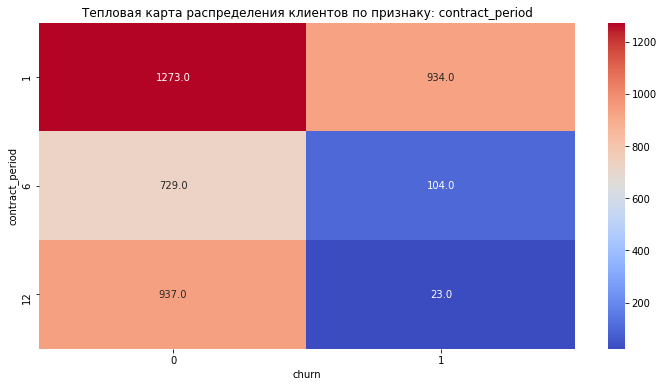

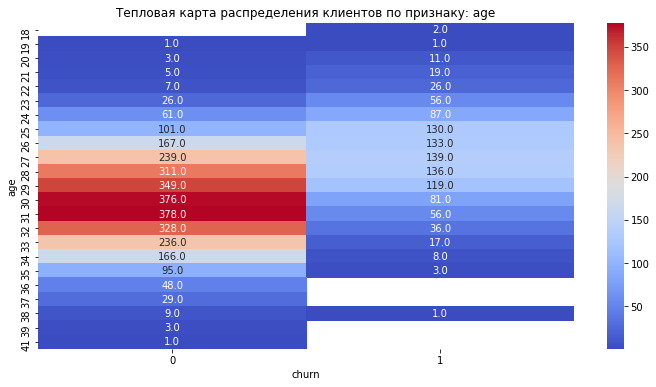

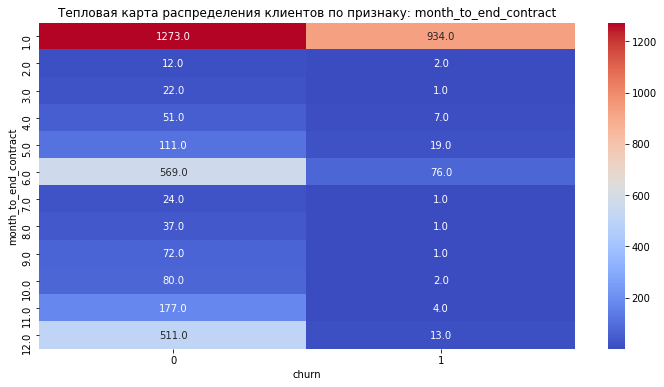

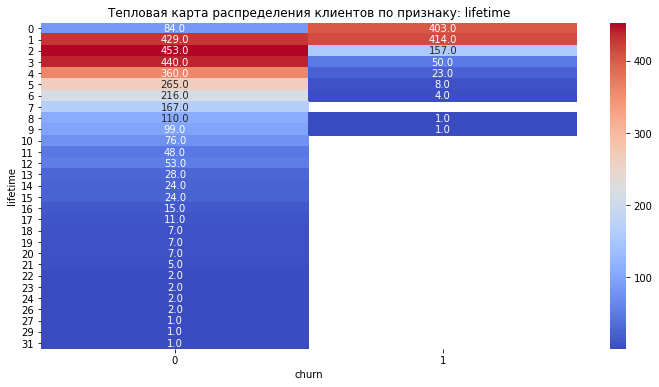

In [11]:
for feature in discrete_columns:
    pt = pd.pivot_table(data, index=feature, columns='churn', values='gender', aggfunc='count')
    plt.figure(figsize = (12,6))
    sns.heatmap(pt, annot=True, fmt='.1f', cmap='coolwarm')
    plt.title('Тепловая карта распределения клиентов по признаку: ' + feature)
    plt.show()

<div style="border:solid blue 1px; padding: 20px"> 
На графиках выше отображено распределение клиентов по дискретным признакам. По ним можно отметить следующее:

- Больше половины клиентов заключают контракт на 1 месяц;
- ~ половина из них покинула клуб в текущем месяце;
- Активнее всего покидали фитнес-клуб клиенты 25-28 лет;
- Среди оставшихся клиентов больше всего лиц 28-32 лет;
- Почти все покинувшие клуб клиенты посещали его не больше 2 месяцев;

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


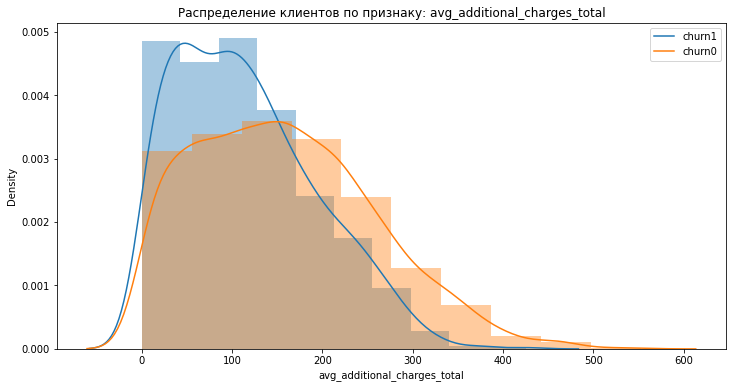

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


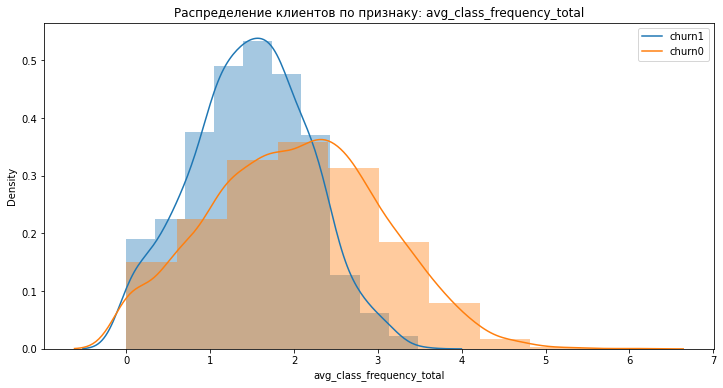

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


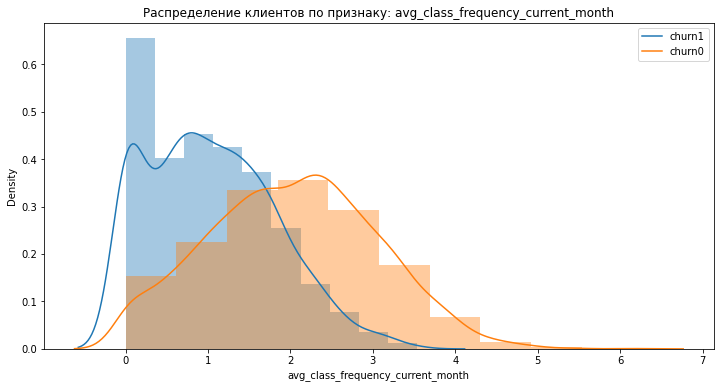

In [12]:
for feature in numeric_columns:
    plt.figure(figsize = (12,6))
    sns.distplot(data[data['churn']==1][feature], bins=10)
    plt.title('Распределение клиентов по признаку: '+ feature)
        
    sns.distplot(data[data['churn']==0][feature], bins=10)
    plt.title('Распределение клиентов по признаку: '+ feature)
    plt.legend(labels=['churn1', 'churn0'])
    plt.show() 

<div style="border:solid blue 1px; padding: 20px"> 
На графиках выше отображено распределение клиентов по числовым непрерывным признакам. По ним можно отметить следующее:

- Клиенты, покинувшие фитнес-клуб в текущем месяце, тратят меньше на другие услуги фитнес-центра, чем оставшиеся;
- Ушедшие клиенты в основном посещали клуб не больше 2 раз в неделю. Причем за последний месяц многие не посетили его ни разу;

<div style="border:solid blue 1px; padding: 20px"> 
Построим также матрицу корреляций

In [13]:
cm = data.corr()

In [14]:
cm

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


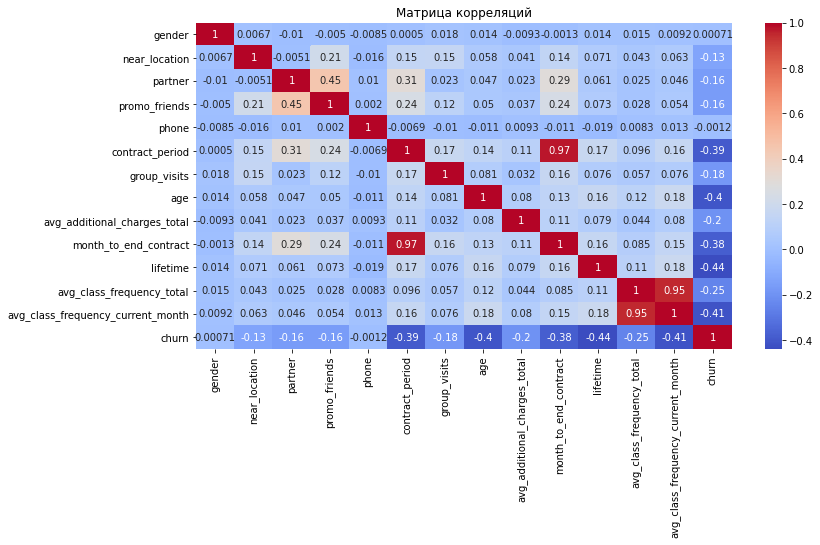

In [15]:
plt.figure(figsize = (12,6))
sns.heatmap(cm, annot=True, cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()

<div style="border:solid blue 1px; padding: 20px"> 
По матрице корреляций видно, что сильно коррелируют между собой признаки "длительность текущего действующего абонемента" и "срок до окончания текущего действующего абонемента", а также "средняя частота посещений в неделю за предыдущий месяц" и "средняя частота посещений в неделю за все время с начала действия абонемента"

<div style="border:solid blue 1px; padding: 20px"> 
Относительно корреляции с целевым признаком (факт оттока в текущем месяце), сильнее всего с ним отрицательно коррелируют признаки "время с момента первого обращения в фитнес-центр", "средняя частота посещений в неделю за предыдущий месяц", "возраст", "длительность текущего действующего абонемента", "срок до окончания текущего действующего абонемента" (т.е., чем они меньше, тем сильнее факт оттока)

### Вывод

Данные представлены в виде целых и вещественных чисел, в них нет пропусков.
Часть признаков (например, "пол", "проживание или работа в районе, где находится фитнес-центр", "сотрудник компании-партнёра клуба" и т.д.) представлены в виде бинарной классификации.

- 51% клиентов фитнес-центра - женщины
- 84,5% живут или работают поблизости
- 48,7% - сотрудники компании-партнёра клуба
- 30,8% записались в рамках акции "приведи друга"
- 90,4% предоставили свой контактный телефон
- 41,2% посещают групповые занятия
- 26,5% клиентов покинули фитнес-клуб в текущем месяце
- Самый популярный тариф - 1 месяц, им пользуется 50% клиентов. Также можно оформить абонемент на 6 месяцев и на год.
- Минимальный возраст клиента - 18 лет, максимальный - 41 год.
- Суммарная выручка от других услуг фитнес-центра в среднем составляет 146,94.
- В среднем по выборке с момента первого обращения в фитнес-центр прошло ~4 месяцев. Самый преданный клиент посещает фитнес-клуб уже 31 месяц (2,5 года).

Различия среди клиентов, кто ушел и тех, кто остался наблюдаются в следующих признаках:
- Среди тех, кто ушел меньше клиентов, живущих/работающих поблизости от фитнес-центра (76,8% против 87,3%);
- Меньше клиентов, записавшихся в рамках акции "приведи друга" (35,5% против 53,4%);
- Меньше клиентов, являющихся сотрудниками компании-партнёра клуба (18,4% против 35,4%);
- Длительность абонемента в среднем ставляет ~2 месяца, в отличие от ~6 месяцев у оставшихся клиентов;
- Меньше клиентов, посещающих групповые занятия (26,9% против 46,4%);
- Меньше суммарная выручка от других услуг фитнес-центра (115 против 158);
- С момента первого обращения в фитнес-центр прошло в среднем менее месяца;
- Посещаемость занятий снизилась с 1,5 занятий в неделю за все время действия абонемента до 1 за предыдущий месяц.

Сильно коррелируют между собой признаки "длительность текущего действующего абонемента" и "срок до окончания текущего действующего абонемента", а также "средняя частота посещений в неделю за предыдущий месяц" и "средняя частота посещений в неделю за все время с начала действия абонемента".

## Модель прогнозирования оттока клиентов

<div style="border:solid blue 1px; padding: 20px"> 
Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце

<div style="border:solid blue 1px; padding: 20px"> 
Разделим наши данные на признаки (матрица X) и целевую переменную (y)

In [16]:
X = data.drop('churn', axis=1)
y = data['churn']

<div style="border:solid blue 1px; padding: 20px"> 
Разделим модель на обучающую и валидационную выборку

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

<div style="border:solid blue 1px; padding: 20px"> 
Как было видно на графиках столбчатых гистограмм и распределения признаков данные не стандартизированы. Поэтому сначала стандартизируем их.

In [18]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

<div style="border:solid blue 1px; padding: 20px"> 
Обучим модель на train-выборке логистической регрессией

In [19]:
lr_model = LogisticRegression(solver='liblinear')

In [20]:
lr_model.fit(X_train_st, y_train)

LogisticRegression(solver='liblinear')

In [21]:
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

In [22]:
print('Метрики для модели логической регрессии')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, lr_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, lr_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, lr_predictions)))

Метрики для модели логической регрессии
Accuracy: 0.92
Precision: 0.85
Recall: 0.83


In [24]:
X_train.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month'],
      dtype='object')

In [25]:
lr_model.coef_

array([[-0.01305072, -0.07530101, -0.08284545, -0.26818022,  0.00521962,
        -0.70374129, -0.38577798, -1.07435913, -0.54101953, -0.52008862,
        -3.72005718,  3.29050594, -4.42649218]])

<div style="border:solid blue 1px; padding: 20px"> 
Самый большой вес у коэффициента  "средняя частота посещений в неделю за предыдущий месяц"

<div style="border:solid blue 1px; padding: 20px"> 
Теперь обучим модель на train-выборке случайным лесом

In [26]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

In [27]:
rf_model.fit(X_train_st, y_train)

RandomForestClassifier(random_state=0)

In [28]:
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

In [29]:
print('Метрики для модели случайного леса')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))

Метрики для модели случайного леса
Accuracy: 0.92
Precision: 0.84
Recall: 0.81


In [30]:
pd.DataFrame({'feature': X_train.columns, 'importance': rf_model.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
10,lifetime,0.276499
12,avg_class_frequency_current_month,0.180170
11,avg_class_frequency_total,0.129883
7,age,0.119129
8,avg_additional_charges_total,0.091473
9,month_to_end_contract,0.068855
5,contract_period,0.065964
6,group_visits,0.015652
0,gender,0.012425
2,partner,0.012285


<div style="border:solid blue 1px; padding: 20px"> 
Самый большой вес у коэффициента  "время с момента первого обращения в фитнес-центр"

<div style="border:solid blue 1px; padding: 20px"> 
По метрикам лучше себя показала модель логической регрессии. Но как мы выяснили на предыдущем шаге у нас есть 2 пары сильно коррелирующих признаков. Попробуем удалить по одному признаку из каждой пары и обучить модели заново.

<div style="border:solid blue 1px; padding: 20px"> 
Чтобы избавиться от мультиколлинеарности, удалим из датафрейма "срок до окончания текущего действующего абонемента" и "средняя частота посещений в неделю за предыдущий месяц". 

In [31]:
data_2 = data.drop(['month_to_end_contract', 'avg_class_frequency_current_month'], axis = 1)

In [32]:
X_2 = data_2.drop('churn', axis=1)
y_2 = data_2['churn']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_2)
X_train_st_2 = scaler.transform(X_train_2)
X_test_st_2 = scaler.transform(X_test_2)

lr_model_2 = LogisticRegression(solver='liblinear')
lr_model_2.fit(X_train_st_2, y_train_2)
lr_predictions_2 = lr_model_2.predict(X_test_st_2)
lr_probabilities_2 = lr_model_2.predict_proba(X_test_st_2)[:,1]
print('Метрики для модели логической регрессии')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test_2, lr_predictions_2)))
print('Precision: {:.2f}'.format(precision_score(y_test_2, lr_predictions_2)))
print('Recall: {:.2f}'.format(recall_score(y_test_2, lr_predictions_2)))

rf_model_2 = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model_2.fit(X_train_st_2, y_train_2)
rf_predictions_2 = rf_model_2.predict(X_test_st_2)
rf_probabilities_2 = rf_model_2.predict_proba(X_test_st_2)[:,1]
print('Метрики для модели случайного леса')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test_2, rf_predictions_2)))
print('Precision: {:.2f}'.format(precision_score(y_test_2, rf_predictions_2)))
print('Recall: {:.2f}'.format(recall_score(y_test_2, rf_predictions_2)))

Метрики для модели логической регрессии
Accuracy: 0.90
Precision: 0.79
Recall: 0.81
Метрики для модели случайного леса
Accuracy: 0.89
Precision: 0.79
Recall: 0.76


In [33]:
display(X_train_2.columns)
display(lr_model_2.coef_)

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'lifetime',
       'avg_class_frequency_total'],
      dtype='object')

array([[ 0.04880859, -0.08713747, -0.0531401 , -0.21410759, -0.11685712,
        -1.29532112, -0.35411787, -1.08031634, -0.55904449, -3.78566134,
        -0.71948585]])

In [34]:
pd.DataFrame({'feature': X_train_2.columns, 'importance': rf_model_2.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
9,lifetime,0.336627
10,avg_class_frequency_total,0.167682
7,age,0.145872
8,avg_additional_charges_total,0.137607
5,contract_period,0.113528
6,group_visits,0.022918
3,promo_friends,0.017572
2,partner,0.017395
0,gender,0.017353
1,near_location,0.013489


<div style="border:solid blue 1px; padding: 20px"> 
Самый большой вес по обоим методам у коэффициента  "время с момента первого обращения в фитнес-центр"

<div style="border:solid blue 1px; padding: 20px"> 
Качество модели упало, значит удаленный признак нужно вернуть

<div style="border:solid blue 1px; padding: 20px"> 
Попробуем также удалить признаки с нулевой корреляцией с основным признаком, а именно "пол" и "наличие контактного телефона" и обучить модели заново

In [35]:
data_3 = data.drop(['age', 'phone'], axis = 1)

X_3 = data_3.drop('churn', axis=1)
y_3 = data_3['churn']

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_3)
X_train_st_3 = scaler.transform(X_train_3)
X_test_st_3 = scaler.transform(X_test_3)

lr_model_3 = LogisticRegression(solver='liblinear')
lr_model_3.fit(X_train_st_3, y_train_3)
lr_predictions_3 = lr_model_3.predict(X_test_st_3)
lr_probabilities_3 = lr_model_3.predict_proba(X_test_st_3)[:,1]
print('Метрики для модели логической регрессии')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test_3, lr_predictions_3)))
print('Precision: {:.2f}'.format(precision_score(y_test_3, lr_predictions_3)))
print('Recall: {:.2f}'.format(recall_score(y_test_3, lr_predictions_3)))

rf_model_3 = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model_3.fit(X_train_st_3, y_train_3)
rf_predictions_3 = rf_model_3.predict(X_test_st_3)
rf_probabilities_3 = rf_model_3.predict_proba(X_test_st_3)[:,1]
print('Метрики для модели случайного леса')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test_3, rf_predictions_3)))
print('Precision: {:.2f}'.format(precision_score(y_test_3, rf_predictions_3)))
print('Recall: {:.2f}'.format(recall_score(y_test_3, rf_predictions_3)))

Метрики для модели логической регрессии
Accuracy: 0.91
Precision: 0.80
Recall: 0.83
Метрики для модели случайного леса
Accuracy: 0.91
Precision: 0.80
Recall: 0.83


In [36]:
display(X_train_3.columns)
display(lr_model_3.coef_)

Index(['gender', 'near_location', 'partner', 'promo_friends',
       'contract_period', 'group_visits', 'avg_additional_charges_total',
       'month_to_end_contract', 'lifetime', 'avg_class_frequency_total',
       'avg_class_frequency_current_month'],
      dtype='object')

array([[-0.00550577, -0.06098794, -0.0703693 , -0.22763012, -0.85811264,
        -0.38743426, -0.52278601, -0.30186557, -3.75207365,  3.3379607 ,
        -4.465988  ]])

In [37]:
pd.DataFrame({'feature': X_train_3.columns, 'importance': rf_model_3.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
8,lifetime,0.295695
10,avg_class_frequency_current_month,0.223218
9,avg_class_frequency_total,0.168657
6,avg_additional_charges_total,0.110367
4,contract_period,0.070542
7,month_to_end_contract,0.068443
5,group_visits,0.015302
2,partner,0.012505
3,promo_friends,0.012300
0,gender,0.012128


<div style="border:solid blue 1px; padding: 20px"> 
Самый большой вес по методу случайного леса у коэффициента "время с момента первого обращения в фитнес-центр", а по методу логической регрессии - "средняя частота посещений в неделю за предыдущий месяц"

<div style="border:solid blue 1px; padding: 20px"> 
Качество модели упало, значит удаленные признаки нужно также вернуть

### Вывод

Эффективнее оказалась модель прогнозирования оттока клиентов, построенная методом логической регрессии. По ней accuracy составила 0,92, precision - 0,85, recall - 0,83 (в отличие от метода случайного леса: 0,92; 0,84 и 0,81 соответственно).

Для сравнения модель была обучена после удаления сильно коррелирующих признаков, таких как "срок до окончания текущего действующего абонемента" (из пары  "длительность текущего действующего абонемента" и "срок до окончания текущего действующего абонемента") и "средняя частота посещений в неделю за предыдущий месяц" (из пары  "средняя частота посещений в неделю за предыдущий месяц" и "средняя частота посещений в неделю за все время с начала действия абонемента"); а также после удаления признаков с нулевой корреляцией - "пол" и "наличие контактного телефона". Но это ухудшило качество модели, поэтому остановимся на первом варианте построения, использующего все признаки.

## Кластеризация клиентов

<div style="border:solid blue 1px; padding: 20px"> 
Построим матрицу расстояний на стандартизованной матрице признаков и нарисуем дендрограмму

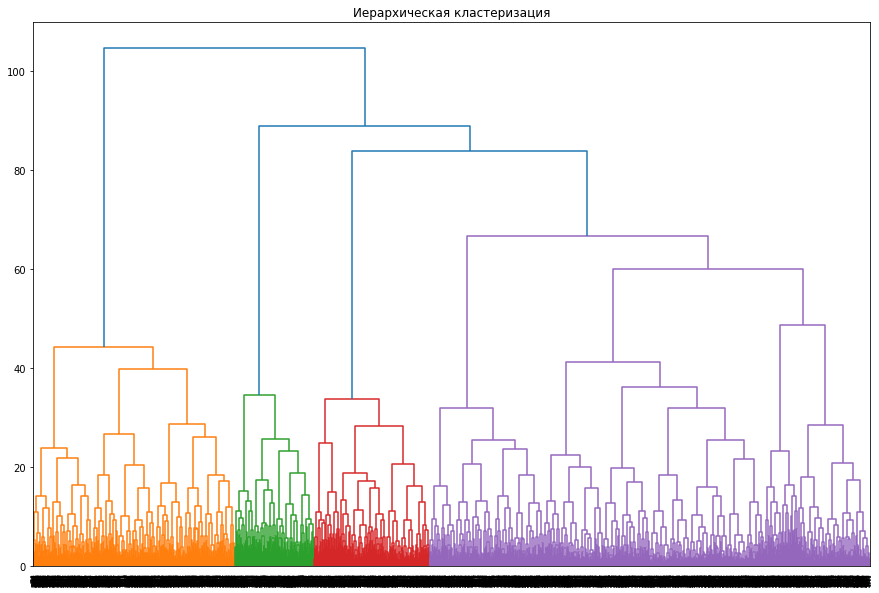

In [38]:
X_sc = scaler.fit_transform(X)

linked = linkage(X_sc, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show() 

<div style="border:solid blue 1px; padding: 20px"> 
Предложенное оптимальное число кластеров 5 — пять разных цветов на графике.

<div style="border:solid blue 1px; padding: 20px"> 
Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Число кластеров примем равным 5.

In [39]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc) 

<div style="border:solid blue 1px; padding: 20px"> 
Сохраняем метки кластера в поле нашего датасета

In [40]:
data['cluster'] = labels

<div style="border:solid blue 1px; padding: 20px"> 
Выведем статистику по средним значениям наших признаков по кластеру

In [41]:
data.groupby('cluster')['age'].count()

cluster
0    1010
1     385
2     505
3    1262
4     838
Name: age, dtype: int64

In [42]:
data.groupby('cluster').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


<div style="border:solid blue 1px; padding: 20px"> 
Можно отметить, что в 1 кластере большая часть клиентов заключила годовой контракт, также высока доля клиентов, записавшихся в рамках акции «приведи друга» и являющихся сотрудниками компании-партнёра клуба.

В 2 кластере ни один пользователь не предоставил свой контактный телефон, 26% из них покинули клуб в текущем месяце.

В 3 кластере все пользователи живут/работают далеко от клуба, 44% из них покинули клуб в текущем месяце.
    
В 4 кластере все пользователи живут/работают рядом с клубом, 51% клиентов покинули клуб в текущем месяце.

В 5 кластере собраны самые активные пользователи клуба (в среднем ~3 посещения в неделю).

Таким образом самые надежные кластеры - 1 и 5, в них самая маленькая доля оттока.

### Вывод

Всего представлено 5 кластеров, из них 1 и 5 самые надежные: в них наименьшая доля оттока (всего ~3% и ~7%).
Особое внимание стоит уделить 4 кластеру. Это самый многочисленный кластер и среди его представителей 51% покинули фитнес-клуб в текущем месяце.

## Выводы

Таким образом на основании проведенного анализа можно предложить следующие рекомендации:
1) Золотые клиенты - представители первого кластера. Это второй по численности кластер. Большая часть его клиентов заключает долгосрочный контракт, активно посещает клуб (~ 2 раза в неделю), также по ним велика суммарная выручка от других услуг фитнес-центра. Таких клиентов стоит выделить и предложить дополнительные привилегии (программа лояльности). Такая мера мотивирует их на дальнейшее продолжение контракта, а также "подстягнет" остальных членов клуба к попаданию в "высшую лигу".

2) Представители пятого кластера. Третий по численности кластер, по характеристикам похож на первый. Его представители еще активнее посещают клуб (~ 3 раза в неделю), по ним самая высокая выручка от других услуг фитнес-центра, но здесь меньше продолжительность контрактов (в среднем ~3 месяца против ~11 месяцев). Введя предложенную выше меру мы сможем перевести клиентов из пятого кластера в первый. Долгосрочные контракты куда более выгодны.

3) Представители 4 кластера. Это самый многочисленный кластер и в нем самая высокая доля оттока. С такими клиентами нужно быть "на связи" (писать письма/рассылки со спец. предложениями). Среди данных клиентов самая низкая выручка от других услуг фитнес-центра. Стоит рассмотреть вопрос предложения бесплатных пробных доп. занятий/сеансов массажа/напитков в кафе, чтобы клиенты смогли "распробовать" товар. Также нужно получить обратную связь от тех клиентов, кто уже ушел, чтобы узнать причины и не допустить подобных ошибок в будущем.